You should consider upgrading via the 'pip install --upgrade pip' command.


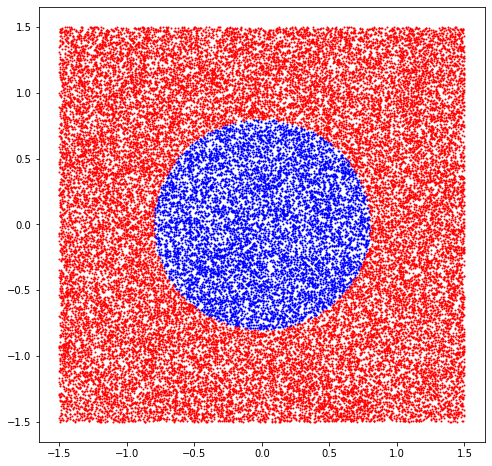

In [162]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
!pip install -q tensorflow==2.0.0-beta1

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

N=40000
K=3
X = K*np.random.rand(N,2) 
X[:,0] = X[:,0]-K/2
X[:,1] = X[:,1]-K/2

Y = np.zeros([N,2])

for i in range(N):
    if (X[i,0])**2+(X[i,1])**2<0.64:
        Y[i,0]=1
    else:
        Y[i,1]=1

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=1, facecolors='b', linewidths=1, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=1, facecolors='r', linewidths=1, label='Class 2')
plt.show()

data = X
labels = Y

In [160]:
hid_layer_units = [6,6]

model = tf.keras.Sequential()
for i in range(len(hid_layer_units)):
    if i == 0:
        model.add(Dense(hid_layer_units[i], input_shape=(2,), activation='relu',kernel_initializer='random_uniform',bias_initializer='random_uniform'))
    else:
        model.add(Dense(hid_layer_units[i], activation='relu',kernel_initializer='random_uniform',bias_initializer='random_uniform'))
model.add(Dense(2, activation='softmax',kernel_initializer='random_uniform'))

# Configure a model for categorical classification.
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model_name = ''.join(str(e) for e in hid_layer_units)+'2'

import os
directory = 'adversarial_example_2D_result/'+'model_'+model_name
if not os.path.exists(directory):
    os.makedirs(directory)
    
model.save(directory+'/'+model_name+'_model.h5') 

In [171]:
from tensorflow.keras import backend as K
#define function list to get each layer output
get_layer_output_functions = []
for i in range(len(hid_layer_units)+1):
    get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[i].output))

#function to get activation of input data into a list
def get_activation(data): 
    layer_output = []
    for f in get_layer_output_functions:
        layer_output.append(f(data.reshape(1,2))[0])

    for i in range(len(layer_output)):
        layer_output[i][np.flatnonzero(layer_output[i])] = 1
        layer_output[i] = layer_output[i].astype(int)
        
    act_list = layer_output
    return act_list

#assign a different color to each different activation,use color index
def assign_color(activations,act_index):
    color_index = 0
    for i in range(len(hid_layer_units)):
        binary = ''.join(str(e) for e in activations[act_index][i].astype(int))
        color_index+=int(binary,2)
    return color_index

interval = int(np.ceil(255/2**(np.sum(hid_layer_units)/3.0)))
R = range(0,255,interval)
G = range(0,255,interval)
B = range(0,255,interval)
rv,gv,bv = np.meshgrid(R,G,B)
colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
np.random.shuffle(colors)

In [157]:
import multiprocessing
from multiprocessing import Pool
from functools import partial
import pdb

Grid = 200
k = 2
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()


#loop for all data points to get activations
i_data = 0
activations = []

for test_data in X_test:
    print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end="\r")
    activations.append(get_activation(test_data))
    i_data = i_data + 1
print(end="\n")

f = partial(assign_color,activations)

i_color=0
data_activation_color=[]

pool = Pool(8)
for y in pool.map(f, range(len(activations))):
    i_color+=1
    print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
    data_activation_color.append(y)
print(end="\n")
# for y in range(len(activations)):
#     i_color+=1
#     print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
#     data_activation_color.append(f(y))
# print(end="\n")
data_activation_color = np.asarray(data_activation_color)
# act_clusters = np.unique(data_activation_color)
# cluster_index = []
# for j in range(len(act_clusters)):
#     cluster_index.append(np.where(data_activation_color == act_clusters[j]))

pool.close()
pool.join()

get activation progress:100%
get data color progress:100%


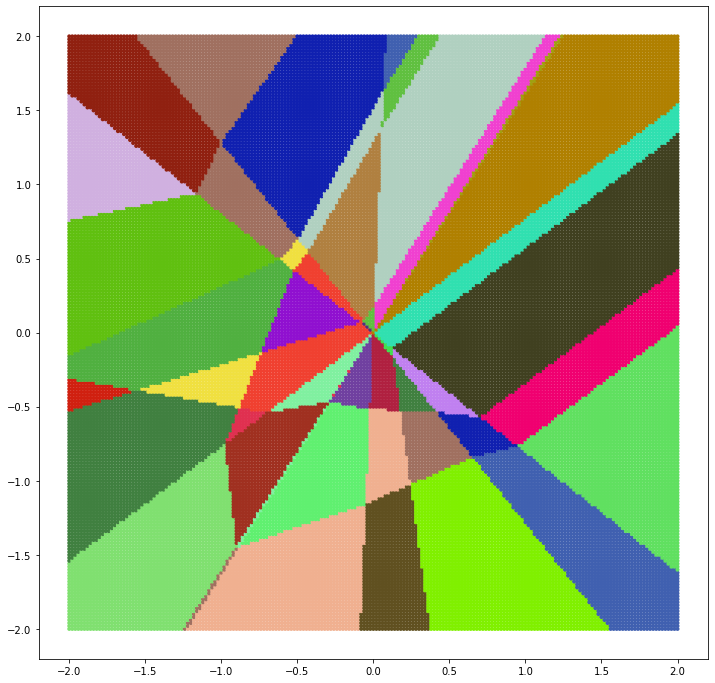

<Figure size 432x288 with 0 Axes>

In [172]:
plt.figure(figsize=(12, 12))
c = colors[data_activation_color]/255
xs = X_test[:, 0]
ys = X_test[:, 1]
plt.scatter(xs, ys, marker='o',s=4, c = c, linewidths=2,cmap = 'gray')
plt.show()
plt.savefig('activation')

In [170]:
colors

In [17]:
#save data and model
model.save(model_name+'model.h5')
np.save('colors.npy',colors)
np.save('activations.npy',activations)
np.save('data_activation_color.npy',data_activation_color)

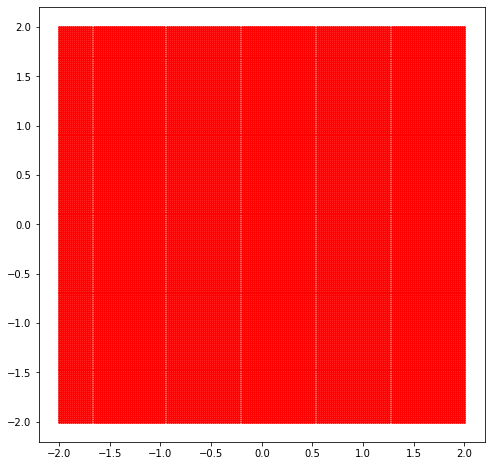

In [37]:
#test
import numpy as np
Grid = 200
k = 2
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()
#np.random.shuffle(X_test)

Y_test = model.predict(X_test)
Y_test = np.rint(Y_test)

zero_class_test = np.where(Y_test[:, 0])
one_class_test = np.where(Y_test[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
plt.show()

In [478]:
#read data and model
from tensorflow.keras.models import load_model
model = load_model(model_name+'model.h5')
colors = np.load('colors.npy')
activations = np.load('activations.npy',allow_pickle=True)
data_activation_color = np.load('data_activation_color.npy')

In [126]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial(input_data, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_data)
    prediction = model(input_data)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_data)
  return gradient 

old_prediction : [[0.50246966 0.49753037]]
new_prediction : [[0.50246966 0.49753037]]


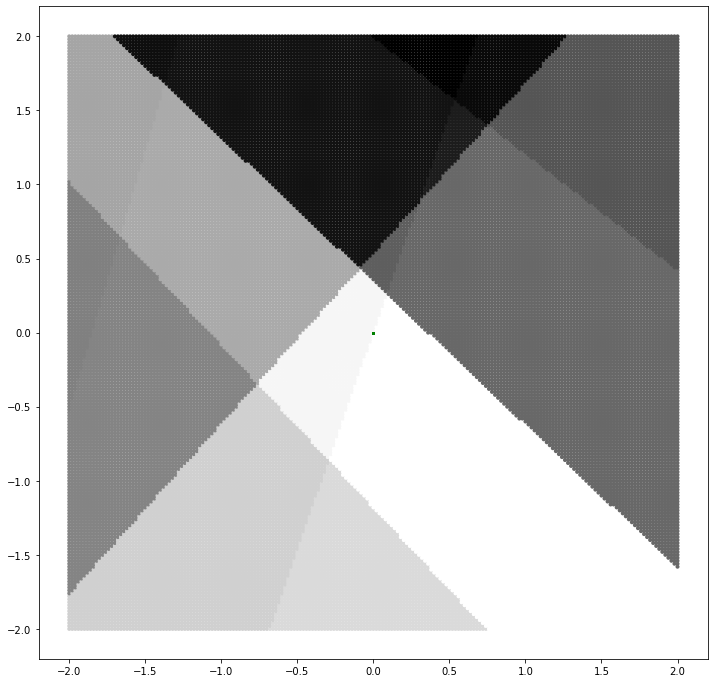

In [136]:
trajectory = []
seed = np.random.randint(40000)
test_x, test_y = [0.000,  0.0]
test = np.array([test_x,test_y])
label = np.array([1,0])
test_tensor = tf.constant(np.copy(test.reshape(1,2)))
trajectory.append(test_tensor)
for i in range(100):
    perturbations = create_adversarial(test_tensor, label)
    test_tensor = test_tensor-0.000005*perturbations/(np.linalg.norm(perturbations)+10**(-8))
    trajectory.append(test_tensor)
    
trajectory = np.asarray(trajectory)
trajectory = trajectory.reshape(len(trajectory),2)

old_prediction = model.predict(test.reshape(1,2))
print('old_prediction :',old_prediction)

new_prediction = model.predict(test_tensor)
print('new_prediction :',new_prediction)

plt.figure(figsize=(12, 12))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color, linewidths=2)
#print(end="\n")

#plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=1, facecolors='g', linewidths=1, label='Class 1')

for k in range(len(trajectory)):
    plt.scatter(trajectory[:,0], trajectory[:,1], marker='o',s=2, color='g', linewidths=1)
#plt.show()
plt.savefig('trajectory')

In [12]:
perturbations = create_adversarial(test_tensor,np.array([1,0]))
perturbations

<tf.Tensor: id=749108, shape=(1, 2), dtype=float64, numpy=array([[-4.79427263e-06,  3.78873324e-06]])>

In [108]:
trajectory[:]

array([[ 0.00000000e+00,  0.00000000e+00],
       [-3.94377634e-06, -3.04196398e-06],
       [-7.88755268e-06, -6.08392796e-06],
       [-1.18313290e-05, -9.12589194e-06],
       [-1.57751054e-05, -1.21678559e-05],
       [-1.97188817e-05, -1.52098199e-05],
       [-2.36626580e-05, -1.82517839e-05],
       [-2.76064344e-05, -2.12937478e-05],
       [-3.15502107e-05, -2.43357118e-05],
       [-3.54939870e-05, -2.73776758e-05],
       [-3.94377634e-05, -3.04196398e-05],
       [-4.33815397e-05, -3.34616038e-05],
       [-4.73253161e-05, -3.65035677e-05],
       [-5.12690924e-05, -3.95455317e-05],
       [-5.52128687e-05, -4.25874957e-05],
       [-5.91566451e-05, -4.56294597e-05],
       [-6.31004214e-05, -4.86714237e-05],
       [-6.70441977e-05, -5.17133876e-05],
       [-7.09879741e-05, -5.47553516e-05],
       [-7.49317504e-05, -5.77973156e-05],
       [-7.88755268e-05, -6.08392796e-05],
       [-8.28193031e-05, -6.38812435e-05],
       [-8.67630794e-05, -6.69232075e-05],
       [-9.

In [128]:
new_prediction = model.predict(test_tensor)
print('new_prediction :',new_prediction)
print('old loss :', loss_object(label, old_prediction))
print('new loss :', loss_object(label, new_prediction))
print('cross entropy loss :', loss_object(np.array([1,0]), np.array([[0,1]]).astype(np.float32)))

new_prediction : [[0.50246966 0.49753037]]
old loss : tf.Tensor(0.68822, shape=(), dtype=float32)
new loss : tf.Tensor(0.68822, shape=(), dtype=float32)
cross entropy loss : tf.Tensor(16.118095, shape=(), dtype=float32)


In [129]:
def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

In [130]:
def get_static_matrix(input_data):
    weight_matrix = []
    for i in range(len(model.layers)):
        weights,biases = model.layers[i].get_weights()
        weights = np.transpose(weights)
        weight_matrix.append([weights,biases])
    return weight_matrix

In [131]:
static_matrix = get_static_matrix(test.reshape(1,2))
static_activation = get_activation(test.reshape(1,2))

In [132]:
from sympy import Symbol
x = Symbol('x')
y = Symbol('y')
#input_data = np.array([-0.8,0.5])
input = np.array([x,y])
for i in range(len(model.layers)):
    output = (np.dot(static_matrix[i][0], input)+static_matrix[i][1])*static_activation[i]
    print('layer',i+1,': ',output)
    input = output

layer 1 :  [-0.0382079370319843*x - 0.0395260564982891*y + 0.0137439258396626
 0.0493411682546139*x - 0.0428910963237286*y + 0.0228947512805462
 0.0425427667796612*x + 0.0386338271200657*y + 0.04566765204072
 -0.00924143940210342*x - 0.0117537267506123*y + 0.0234368182718754 0
 0.0201725475490093*x - 0.00575768947601318*y + 0.0373326800763607]
layer 2 :  [0 -0.000151353358007492*x + 0.00229423979828812*y + 0.048322130923689
 0.000264436088258213*x - 0.00116966582384415*y + 0.013642119354294 0 0 0]
layer 3 :  [5.70358893136088e-6*x - 4.91694435740869e-5*y - 0.0294878473352886
 1.11697257345435e-5*x - 5.52383062965032e-5*y - 0.03936644958581]


In [133]:
for i in range(len(model.layers)):
    [layer_output] = get_layer_output_functions[i](test.reshape(1,2))
    print('layer ', i+1, ': ', layer_output)

layer  1 :  [0.01374393 0.02289475 0.04566765 0.02343682 0.         0.03733268]
layer  2 :  [0.         0.04832213 0.01364212 0.         0.         0.        ]
layer  3 :  [0.50246966 0.49753037]


In [50]:
static_matrix

[[array([[ 0.04533586, -0.04293444],
         [-0.01149189,  0.03868477],
         [-0.00209028, -0.03209664],
         [-0.0465189 , -0.04637174],
         [-0.0185593 , -0.04851809],
         [-0.03554292, -0.02315651]], dtype=float32),
  array([-0.00511818, -0.04837469, -0.0278476 ,  0.02383025,  0.04728511,
          0.03282661], dtype=float32)],
 [array([[-0.027535  ,  0.03400109, -0.03334649,  0.03521322,  0.04696727,
          -0.03169085],
         [ 0.03017845,  0.03201295,  0.0310652 , -0.02939   ,  0.00261828,
          -0.03272693],
         [-0.04757489,  0.02070687, -0.00423235,  0.04959932,  0.04762986,
          -0.0070255 ],
         [ 0.02696263, -0.01845677, -0.04832376, -0.01057649, -0.03950257,
           0.0447933 ],
         [-0.02306621, -0.03336172,  0.0318637 , -0.0077576 , -0.0229671 ,
          -0.02034677],
         [ 0.0143993 , -0.04638643,  0.01328127, -0.04212622, -0.02657654,
           0.03048018]], dtype=float32),
  array([-0.00738304,  0.04383815, -

In [502]:
equivalent_matrix = np.zeros((2,2))
equivalent_matrix[0,0] = output[0].subs({x:1, y: 0})-output3[0].subs({x:0, y: 0})
equivalent_matrix[1,0] = output[1].subs({x:1, y: 0})-output3[1].subs({x:0, y: 0})
equivalent_matrix[0,1] = output[0].subs({x:0, y: 1})-output3[0].subs({x:0, y: 0})
equivalent_matrix[1,1] = output[1].subs({x:0, y: 1})-output3[1].subs({x:0, y: 0})

In [503]:
equivalent_matrix

array([[ 9.77866609, -6.8425408 ],
       [-7.52356385,  5.20314597]])

In [596]:
sum = exp(output[0])+exp(output[1])
v1 = exp(output[0])
v2 = exp(output[1])
loss = -log(v1/sum)
sm = [(v1/sum).subs({x:test_x,y:test_y}),(v2/sum).subs({x:test_x,y:test_y})]
print('softmax :', sm)
print('loss :',loss.subs({x:test_x,y:test_y}))

softmax : [0.919309004701531, 0.0806909952984690]
loss : 0.0841329729884969


In [603]:
diff(loss, x,x).subs({x:test_x,y:test_y})

0

In [88]:
static_matrix[0][0]

array([[-0.02318076, -0.03062657],
       [ 0.04604239, -0.04745373],
       [-0.03238904, -0.00454035],
       [ 0.01388427,  0.01070939],
       [ 0.02467154,  0.04621154],
       [ 0.04194918,  0.03843155],
       [-0.01977139,  0.04487287],
       [ 0.02633708,  0.00019092],
       [ 0.04592839, -0.03832885]], dtype=float32)

In [51]:
static_activation

[array([0, 0, 0, 1, 1, 1]),
 array([0, 1, 0, 1, 1, 1]),
 array([1, 0, 0, 0, 0, 0]),
 array([1, 1])]